# Dinámica de sistemas acoplados

In [113]:
import numpy as np
import matplotlib.pyplot as plt

class HodgkinHuxleySync:
    def __init__(self, I_ext=10.0, g_syn=0.1, V1_init=-70.0, V2_init=-65.0, t_max=100.0, dt=0.01, V_syn=0.0):
        self.C_m = 1.0  # membrane capacitance, in uF/cm^2
        self.g_Na = 120.0  # maximum conductances, in mS/cm^2
        self.g_K = 36.0
        self.g_L = 0.3

        # Nernst reversal potentials, in mV
        self.E_Na = 50.0  
        self.E_K = -77.0
        self.E_L = -54.4

        self.V_syn = V_syn # Synaptic reversal potential, in mV
        self.g_syn = g_syn  # Synaptic conductance, in mS/cm^2
        
        self.I_ext = I_ext  # external current, in uA/cm^2
        self.V1_init = V1_init  # initial membrane potential, in mV
        self.V2_init = V2_init  # initial membrane potential, in mV
        self.dt = dt  # time step, in ms
        self.t = np.arange(0, t_max, dt)  # time array
        
        # Initial conditions for two neurons
        self.V1 = np.zeros(len(self.t))
        self.V2 = np.zeros(len(self.t))
        self.V1[0] = self.V1_init
        self.V2[0] = self.V2_init

        # Initial Calculation of gating parameters for neuron 1
        self.m1 = self.alpha_m(V1_init) / (self.alpha_m(V1_init) + self.beta_m(V1_init))
        self.h1 = self.alpha_h(V1_init) / (self.alpha_h(V1_init) + self.beta_h(V1_init))
        self.n1 = self.alpha_n(V1_init) / (self.alpha_n(V1_init) + self.beta_n(V1_init))

        # Initial Calculation of gating parameters for neuron 2
        self.m2 = self.alpha_m(V2_init) / (self.alpha_m(V2_init) + self.beta_m(V2_init))
        self.h2 = self.alpha_h(V2_init) / (self.alpha_h(V2_init) + self.beta_h(V2_init))
        self.n2 = self.alpha_n(V2_init) / (self.alpha_n(V2_init) + self.beta_n(V2_init))
        
        self.s1 = 0.0  # Synaptic gating variable for neuron 1
        self.s2 = 0.0  # Synaptic gating variable for neuron 2
        self.tau_syn = 3.0  # Synaptic time constant, in ms

    def alpha_m(self, V):
        """ Calculation of alpha parameter for m_inf gating variable:
        m_inf= alpha / (alpha + beta)

        Input:
            V: Membrane Potential (mV)
        """
        return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    
    def beta_m(self, V):
        """ Calculation of beta parameter for m_inf gating variable:
        m_inf= alpha / (alpha + beta)

        Input:
            V: Membrane Potential (mV)
        """
        return 4.0 * np.exp(-(V + 65) / 18)
    
    def alpha_h(self, V):
        """ Calculation of alpha parameter for h_inf gating variable:
        h_inf= alpha / (alpha + beta)

        Input:
            V: Membrane Potential (mV)
        """
        return 0.07 * np.exp(-(V + 65) / 20)
    
    def beta_h(self, V):
        """ Calculation of beta parameter for h_inf gating variable:
        h_inf= alpha / (alpha + beta)

        Input:
            V: Membrane Potential (mV)
        """
        return 1.0 / (1 + np.exp(-(V + 35) / 10))
    
    def alpha_n(self, V):
        return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    
    def beta_n(self, V):
        return 0.125 * np.exp(-(V + 65) / 80)
    
    def s_inf(self, V):
        return 0.5 * (1 + np.tanh(V / 5.0))
    
    def compute_gating_variables(self, V):
        m_inf = self.alpha_m(V) / (self.alpha_m(V) + self.beta_m(V))
        h_inf = self.alpha_h(V) / (self.alpha_h(V) + self.beta_h(V))
        n_inf = self.alpha_n(V) / (self.alpha_n(V) + self.beta_n(V))
        
        tau_m = 1.0 / (self.alpha_m(V) + self.beta_m(V))
        tau_h = 1.0 / (self.alpha_h(V) + self.beta_h(V))
        tau_n = 1.0 / (self.alpha_n(V) + self.beta_n(V))
        
        return m_inf, h_inf, n_inf, tau_m, tau_h, tau_n
    
    def simulate(self):
        for i in range(1, len(self.t)):
            # Compute gating variables for both neurons
            m_inf1, h_inf1, n_inf1, tau_m1, tau_h1, tau_n1 = self.compute_gating_variables(self.V1[i-1])
            m_inf2, h_inf2, n_inf2, tau_m2, tau_h2, tau_n2 = self.compute_gating_variables(self.V2[i-1])
            
            self.m1 += self.dt * (m_inf1 - self.m1) / tau_m1
            self.h1 += self.dt * (h_inf1 - self.h1) / tau_h1
            self.n1 += self.dt * (n_inf1 - self.n1) / tau_n1
            
            self.m2 += self.dt * (m_inf2 - self.m2) / tau_m2
            self.h2 += self.dt * (h_inf2 - self.h2) / tau_h2
            self.n2 += self.dt * (n_inf2 - self.n2) / tau_n2

            # Compute ionic currents for neuron 1
            I_Na1 = self.g_Na * (self.m1**3) * self.h1 * (self.V1[i-1] - self.E_Na)
            I_K1 = self.g_K * (self.n1**4) * (self.V1[i-1] - self.E_K)
            I_L1 = self.g_L * (self.V1[i-1] - self.E_L)
            
            # Compute ionic currents for neuron 2
            I_Na2 = self.g_Na * (self.m2**3) * self.h2 * (self.V2[i-1] - self.E_Na)
            I_K2 = self.g_K * (self.n2**4) * (self.V2[i-1] - self.E_K)
            I_L2 = self.g_L * (self.V2[i-1] - self.E_L)

            # Update synaptic gating variables
            self.s1 += self.dt * (self.s_inf(self.V2[i-1]) - self.s1) / self.tau_syn
            self.s2 += self.dt * (self.s_inf(self.V1[i-1]) - self.s2) / self.tau_syn
            
            # Compute synaptic currents
            I_syn1 = -self.g_syn * self.s1 * (self.V1[i-1] - self.V_syn)
            I_syn2 = -self.g_syn * self.s2 * (self.V2[i-1] - self.V_syn)
            
            # Update membrane potentials for both neurons
            self.V1[i] = self.V1[i-1] + self.dt * (self.I_ext - I_Na1 - I_K1 - I_L1 + I_syn1) / self.C_m
            self.V2[i] = self.V2[i-1] + self.dt * (self.I_ext - I_Na2 - I_K2 - I_L2 + I_syn2) / self.C_m
        
        return self.t, self.V1, self.V2
    
    def plot_membrane_potentials(self):
        # t, V1, V2 = self.simulate()
        plt.figure(figsize=(10, 6))
        plt.plot(self.t, self.V1, label='Neurona 1')
        plt.plot(self.t, self.V2, label='Neurona 2')
        plt.title("Sincronización de dos neuronas Hodgkin-Huxley")
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Potencial de Membrana (mV)")
        plt.xticks(np.arange(min(self.t), max(self.t)+1, 5))
        plt.grid()
        plt.legend()
        plt.show()

    def count_spikes(self, threshold=-10):
        spikes1 = 0
        spikes2 = 0
        for i in range(1, len(self.V1)):
            if self.V1[i-1] < threshold and self.V1[i] >= threshold:
                spikes1 += 1
            if self.V2[i-1] < threshold and self.V2[i] >= threshold:
                spikes2 += 1
        return spikes1 / (self.t[-1] / 1000), spikes2 / (self.t[-1] / 1000)  # return firing rates in Hz
    
    def estimate_phase_shift(self, threshold=-10):
        self.simulate()
        spike_times_1 = []
        spike_times_2 = []

        # Counting of rise flanks
        for i in range(1, len(self.t)):
            if self.V1[i-1] < threshold and self.V1[i] >= threshold:
                spike_times_1.append(self.t[i])
            if self.V2[i-1] < threshold and self.V2[i] >= threshold:
                spike_times_2.append(self.t[i])
        
        if len(spike_times_1) > 1 and len(spike_times_2) > 1:
            T = np.mean(np.diff(spike_times_1))  # Assuming both neurons have similar periods
            
            # Initialization of empty list
            phase_shifts = []
            time_shifts = []
            
            print(list(spike_times_1))
            print(list(spike_times_2))
                        
            for t1, t2 in zip(spike_times_1, spike_times_2):
                phase_shift = ((t2 - t1) / T) * 2 * np.pi
                time_shift = (t2 - t1)
                phase_shifts.append(phase_shift)
                time_shifts.append(time_shift)
            
            avg_phase_shift = np.mean(phase_shifts)
            avg_time_shift = np.mean(time_shifts)
            avg_percentage_shift = avg_time_shift / T *100
            
            return avg_phase_shift, avg_time_shift, avg_percentage_shift
        else:
            return None


[np.float64(1.94), np.float64(17.18), np.float64(31.85), np.float64(46.49), np.float64(61.14), np.float64(75.78), np.float64(90.43)]
[np.float64(1.85), np.float64(16.830000000000002), np.float64(31.51), np.float64(46.17), np.float64(60.84), np.float64(75.5), np.float64(90.16)]
Desfasaje Estimado: -0.11867889526500396 radianes
Desfasaje en tiempo: -0.27857142857142947 ms
Desfasaje en porcentaje: -1.888833282211071 %


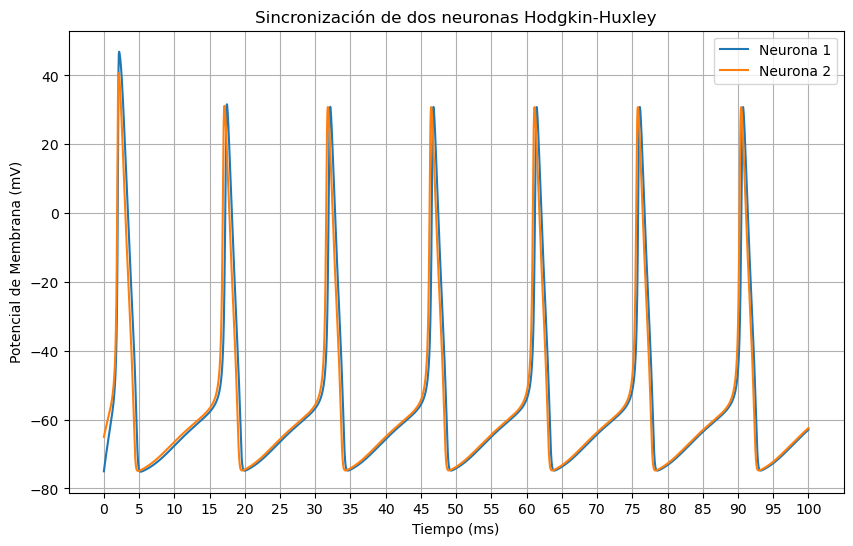

Firing rate for Neuron 1: 70.01 Hz
Firing rate for Neuron 2: 70.01 Hz


In [119]:
# Create a system of two synchronized Hodgkin-Huxley neurons with synaptic interaction
hh_sync = HodgkinHuxleySync(I_ext=10.0, g_syn=0.1, V1_init=-75.0, V2_init=-65.0, t_max=100.0, dt=0.01,V_syn=0)

# hh_sync.simulate()
phase_shift, time_shift, avg_percentage_shift = hh_sync.estimate_phase_shift()
print(f"Desfasaje Estimado: {phase_shift} radianes")
print(f"Desfasaje en tiempo: {time_shift} ms")
print(f"Desfasaje en porcentaje: {avg_percentage_shift} %")


# Simulate and plot the membrane potentials of both neurons over time
hh_sync.plot_membrane_potentials()

# Count the number of spikes (firing rate in Hz) for both neurons
firing_rate1, firing_rate2 = hh_sync.count_spikes(threshold=-10)
print(f"Firing rate for Neuron 1: {firing_rate1:.2f} Hz")
print(f"Firing rate for Neuron 2: {firing_rate2:.2f} Hz")


[np.float64(1.94), np.float64(17.1), np.float64(31.68), np.float64(46.230000000000004), np.float64(60.78), np.float64(75.34), np.float64(89.89), np.float64(104.45)]
[np.float64(28.47), np.float64(42.93), np.float64(57.49), np.float64(72.06), np.float64(86.62), np.float64(101.18)]
Desfasaje Estimado: 11.132513934172318 radianes
Desfasaje en tiempo: 25.94666666666667 ms
Desfasaje en porcentaje: 177.17946216629272 %


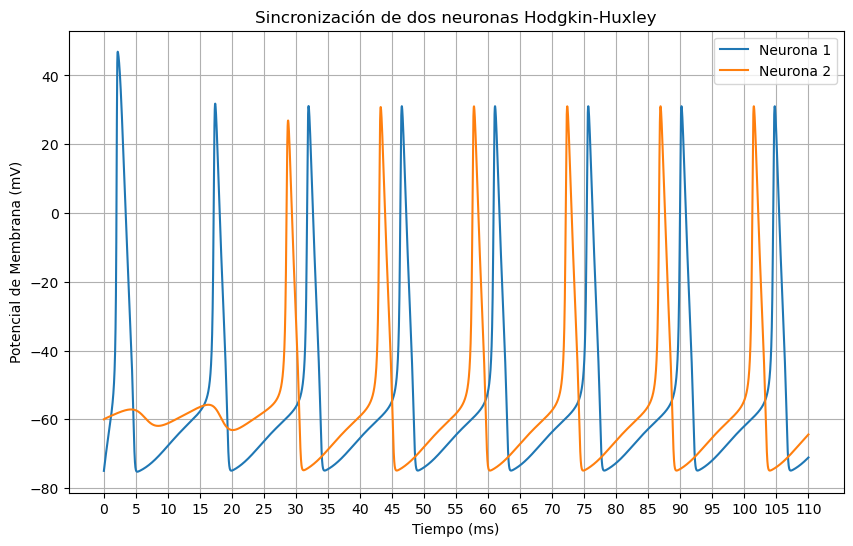

Firing rate for Neuron 1: 72.73 Hz
Firing rate for Neuron 2: 54.55 Hz


In [120]:
# Create a system of two synchronized Hodgkin-Huxley neurons with synaptic interaction
hh_sync = HodgkinHuxleySync(I_ext=10.0, g_syn=0.001, V1_init=-75.0, V2_init=-60.0, t_max=110.0, dt=0.01,V_syn=0)

# hh_sync.simulate()
phase_shift, time_shift, avg_percentage_shift = hh_sync.estimate_phase_shift()
print(f"Desfasaje Estimado: {phase_shift} radianes")
print(f"Desfasaje en tiempo: {time_shift} ms")
print(f"Desfasaje en porcentaje: {avg_percentage_shift} %")


# Simulate and plot the membrane potentials of both neurons over time
hh_sync.plot_membrane_potentials()

# Count the number of spikes (firing rate in Hz) for both neurons
firing_rate1, firing_rate2 = hh_sync.count_spikes(threshold=-10)
print(f"Firing rate for Neuron 1: {firing_rate1:.2f} Hz")
print(f"Firing rate for Neuron 2: {firing_rate2:.2f} Hz")


[np.float64(1.94), np.float64(17.1), np.float64(32.03), np.float64(47.11), np.float64(62.21), np.float64(77.24), np.float64(92.18)]
[np.float64(28.38), np.float64(42.75), np.float64(57.28), np.float64(71.82000000000001), np.float64(86.37)]
Desfasaje Estimado: 10.545223638552335 radianes
Desfasaje en tiempo: 25.242 ms
Desfasaje en porcentaje: 167.83244680851064 %


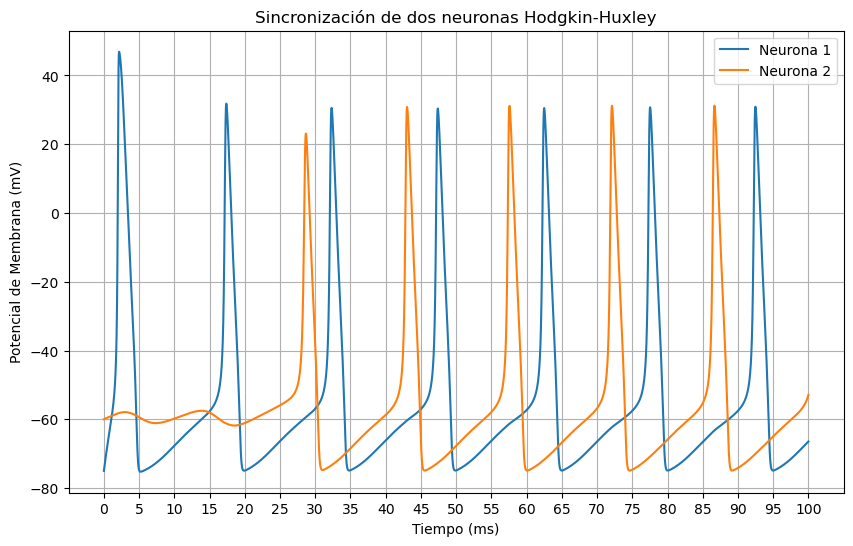

Firing rate for Neuron 1: 70.01 Hz
Firing rate for Neuron 2: 50.01 Hz


In [122]:
# Create a system of two synchronized Hodgkin-Huxley neurons with synaptic interaction
hh_sync = HodgkinHuxleySync(I_ext=10.0, g_syn=0.1, V1_init=-75.0, V2_init=-60.0, t_max=100.0, dt=0.01,V_syn=-80)

# hh_sync.simulate()
phase_shift, time_shift, avg_percentage_shift = hh_sync.estimate_phase_shift()
print(f"Desfasaje Estimado: {phase_shift} radianes")
print(f"Desfasaje en tiempo: {time_shift} ms")
print(f"Desfasaje en porcentaje: {avg_percentage_shift} %")


# Simulate and plot the membrane potentials of both neurons over time
hh_sync.plot_membrane_potentials()

# Count the number of spikes (firing rate in Hz) for both neurons
firing_rate1, firing_rate2 = hh_sync.count_spikes(threshold=-10)
print(f"Firing rate for Neuron 1: {firing_rate1:.2f} Hz")
print(f"Firing rate for Neuron 2: {firing_rate2:.2f} Hz")